## **Fixação Redes Neurais Artificiais**

In [123]:
!wget -q 'https://raw.githubusercontent.com/OviedoVR/ML_especializacao_2025/refs/heads/main/dados/fixacao/kidney_disease_dataset.csv' -O 'kidney.csv'

In [165]:
# Bibliotecas:
# Arrays e dataframes:
import numpy as np
import pandas as pd

# Data Viz:
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.plotting.backend = 'plotly'
import plotly.express as px

# Modelagem
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# RNA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Processamento sem alocar 100% da GPU:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from sklearn.metrics import confusion_matrix, classification_report

Entendimento dos dados:

1. Verificar tamanho do dataset
2. Tipos de dados
3. Estatísticas descritivas
4. Percentual de nulos/dados ausentes
5. Outliers
6. Correlações (multicolinearidade)

Modelagem:
1. Seleção das features e resposta
2. Pré-processamento (scaling, codificação de categóricas)
3. Arquitetutra RNA e treino

Avaliação do modelo:
1. Predições e avaliar performance

In [125]:
# Coleta de dados:
dados = pd.read_csv('kidney.csv')
dados.head()

Age  Creatinine_Level   BUN  Diabetes  Hypertension   GFR  Urine_Output  \
0   71              0.30  40.9         0             1  46.8        1622.0   
1   34              1.79  17.1         0             0  43.8        1428.0   
2   80              2.67  15.0         0             1  78.2        1015.0   
3   40              0.97  31.1         0             1  92.8        1276.0   
4   43              2.05  22.8         1             1  62.2        1154.0   

   CKD_Status  Dialysis_Needed  
0           1                0  
1           1                0  
2           1                0  
3           1                0  
4           0                0

## **Entendimento dos dados**

In [126]:
# Tamanho:
linhas, colunas = dados.shape
print(f'Linhas: {linhas}')
print(f'Colunas: {colunas}')

Linhas: 2304
Colunas: 9


In [127]:
# Tipo de dados:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
 8   Dialysis_Needed   2304 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 162.1 KB


In [128]:
# Estatísticas Descritivas:
descritivas = dados.describe().T
descritivas['cv'] = descritivas['std'] / descritivas['mean']
descritivas.style.background_gradient(subset='cv', cmap='Blues')

In [129]:
# Dados nulos:
dados.isna().sum() / len(dados) * 100

Age                 0.0
Creatinine_Level    0.0
BUN                 0.0
Diabetes            0.0
Hypertension        0.0
GFR                 0.0
Urine_Output        0.0
CKD_Status          0.0
Dialysis_Needed     0.0
dtype: float64

In [130]:
dados[['Age']].boxplot(width=400, template='plotly_dark')

In [131]:
dados[['Creatinine_Level']].boxplot(width=400, template='plotly_dark')

In [132]:
dados[['BUN']].boxplot(width=400, template='plotly_dark')

In [133]:
dados['Diabetes'].value_counts(normalize=True)

Diabetes
0    0.593316
1    0.406684
Name: proportion, dtype: float64

In [134]:
dados['Diabetes'].value_counts(normalize=True).plot(kind='bar', width=600, height=300, template='plotly_dark')

In [135]:
dados['Hypertension'].value_counts(normalize=True).plot(kind='bar', width=600, height=300, template='plotly_dark')

In [136]:
dados[['GFR']].boxplot(width=400, template='plotly_dark')

In [137]:
dados[['Urine_Output']].boxplot(width=400, template='plotly_dark')

In [138]:
dados['CKD_Status'].value_counts(normalize=True)

CKD_Status
1    0.508681
0    0.491319
Name: proportion, dtype: float64

* Proporção de pacientes com alguma doença renal, na base, é praticamente parelha

In [139]:
dados['Dialysis_Needed'].value_counts(normalize=True)

Dialysis_Needed
0    0.986545
1    0.013455
Name: proportion, dtype: float64

> Outliers

- `Creatinine_Level`: valores acima de 3.8
- `BUN`: valores acima de 61
- `Urine_Output`: valores acima de 2650
- Proporções balanceadas em: `Diabetes`, `Hypertension`, `CKD_Status`
- Classes desbalanceadas: `Dialysis_Needed`



In [140]:
dados.drop('Dialysis_Needed', axis=1, inplace=True)

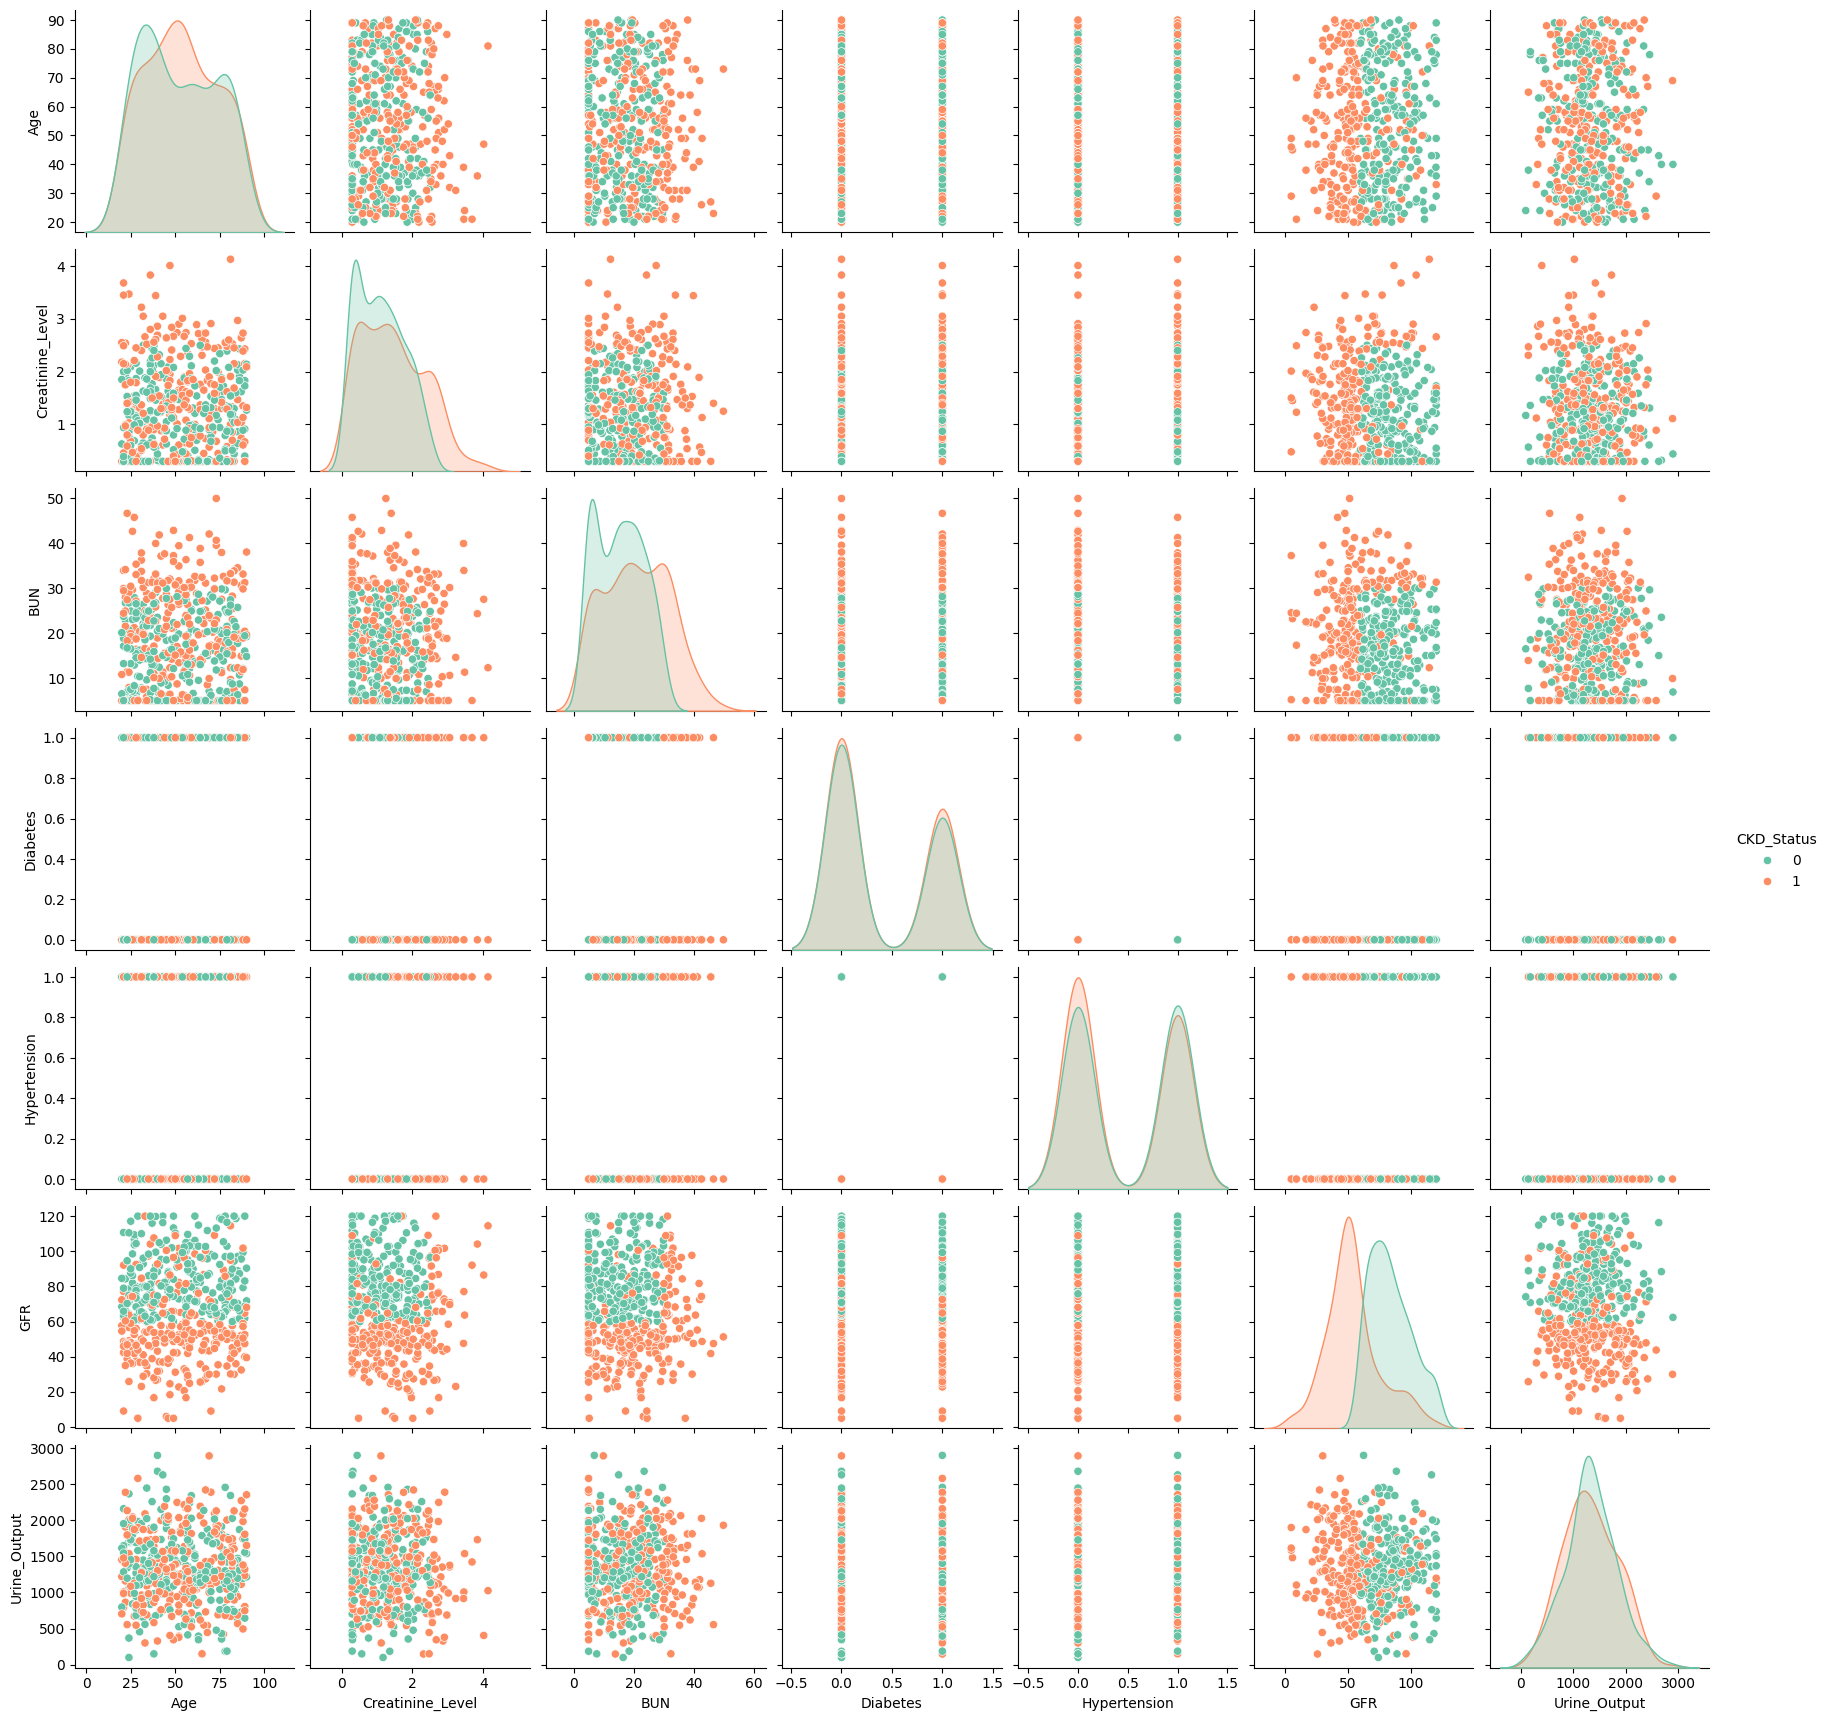

In [141]:
sns.pairplot(dados.sample(500), hue='CKD_Status', palette='Set2')

<Axes: >

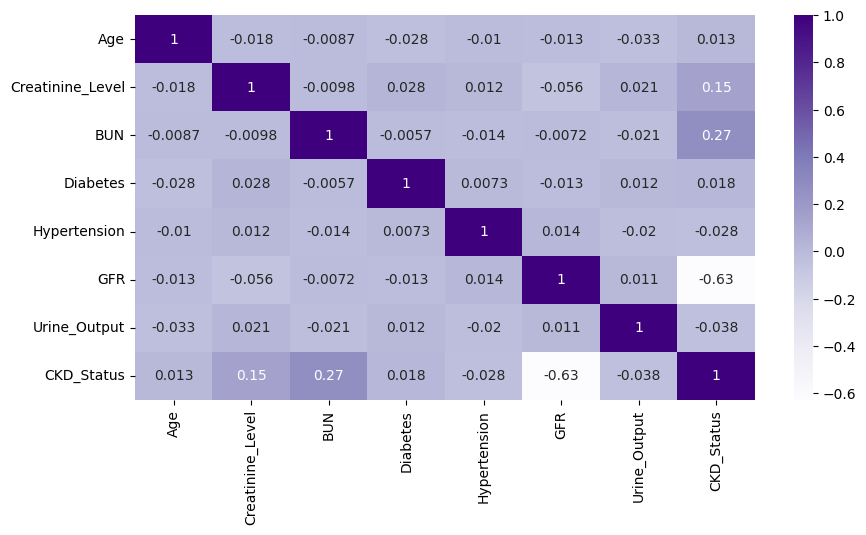

In [142]:
correlacoes = dados.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(correlacoes, annot=True, cmap='Purples', ax=ax)

## **Modelagem**

In [143]:
# Selecção features e resposta:
x = dados.drop('CKD_Status', axis=1).to_numpy()
y = dados['CKD_Status'].to_numpy()

# Divisão treino/teste:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=50)

print(x_train.shape)
print(x_test.shape)

(1728, 7)
(576, 7)


In [144]:
# Normalização:
scaler_x = StandardScaler()
xtrain_std = scaler_x.fit_transform(x_train)
xtest_std = scaler_x.transform(x_test)

In [145]:
rede = keras.Sequential()

# Camada 1:
rede.add(layers.Dense(15,
                                        input_dim=xtrain_std.shape[1],
                                        activation='tanh')
)
# Camada 2:
rede.add(layers.Dense(15,
                                        input_dim=xtrain_std.shape[1],
                                        activation='tanh')
)
# Camada 3:
rede.add(layers.Dense(15,
                                        input_dim=xtrain_std.shape[1],
                                        activation='tanh')
)
# Camada de saída:
rede.add(layers.Dense(1, activation='sigmoid'))


# Compilação do Modelo
rede.compile(loss='binary_crossentropy',
                         optimizer=keras.optimizers.Adam(),
                         metrics=[keras.metrics.AUC(name='auc')])

# Resumo:
rede.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 616 (2.41 KB)

 Trainable params: 616 (2.41 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
rna_earlystop = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    min_delta=0.02,
    patience = 50,
    verbose=0,
    mode='max',
    restore_best_weights=True
)

historico = rede.fit(
    x=xtrain_std,
    y=y_train,
    epochs=200,
    batch_size=24,
    validation_split=0.15,
    callbacks=[rna_earlystop]
)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.7152 - loss: 0.6472 - val_auc: 0.8320 - val_loss: 0.5123
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8596 - loss: 0.4801 - val_auc: 0.9079 - val_loss: 0.4037
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.9204 - loss: 0.3768 - val_auc: 0.9208 - val_loss: 0.3689
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9167 - loss: 0.3730 - val_auc: 0.9238 - val_loss: 0.3607
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9201 - loss: 0.3639 - val_auc: 0.9265 - val_loss: 0.3559
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9132 - loss: 0.3819 - val_auc: 0.9288 - val_loss: 0.3532
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9319 - loss: 0.3376 - val_auc: 0.9319 - val_loss: 0.3405
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9330 - loss: 0.3382 - val_auc: 0.9371 - val_loss: 0.3355
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9327

In [148]:
score_train, metric_train = rede.evaluate(xtrain_std, y_train, verbose=0)
score_test, metric_test = rede.evaluate(xtest_std, y_test, verbose=0)

print(f'AUC no conjunto de treino: {round(metric_train*100, 1)}%')
print(f'AUC no conjunto de teste: {round(metric_test*100, 1)}%')

AUC no conjunto de treino: 99.9%
AUC no conjunto de teste: 99.5%


In [158]:
fig = px.line(historico.history['auc'], template='simple_white')
fig.update_layout(title='AUC Treino', width=600, height=300)
fig.show()

In [157]:
fig = px.line(historico.history['val_auc'], template='simple_white')
fig.update_layout(title='AUC Teste', width=600, height=300)
fig.show()

In [160]:
fig = px.line(historico.history['loss'], template='simple_white', color_discrete_sequence=['orange'])
fig.update_layout(title='Loss Treino', width=600, height=300)
fig.show()

In [161]:
fig = px.line(historico.history['val_loss'], template='simple_white', color_discrete_sequence=['orange'])
fig.update_layout(title='Loss Teste', width=600, height=300)
fig.show()

In [164]:
# Predições para o conjunto de teste
ytest_pred_prob = rede.predict(xtest_std)

# Convertendo probabilidades em classes (0 ou 1) usando um limiar de 0.7
ytest_pred_class = (ytest_pred_prob > 0.65).astype(int)

# Exibindo os valores reais e preditos
print(f'Valores y (real)\n{y_test[0:5]}')  # ytest contém as classes reais (0 ou 1)
print('---' * 10)
print(f'Valores de y (predito - probabilidades)\n{ytest_pred_prob[0:5]}')  # Probabilidades preditas
print('---' * 10)
print(f'Valores de y (predito - classes)\n{ytest_pred_class[0:5]}')  # Classes preditas (0 ou 1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Valores y (real)
[0 1 1 0 0]
------------------------------
Valores de y (predito - probabilidades)
[[8.4148080e-04]
 [9.9999642e-01]
 [9.9996722e-01]
 [3.5645459e-02]
 [3.1998405e-07]]
------------------------------
Valores de y (predito - classes)
[[0]
 [1]
 [1]
 [0]
 [0]]


## **Avaliação de performance**

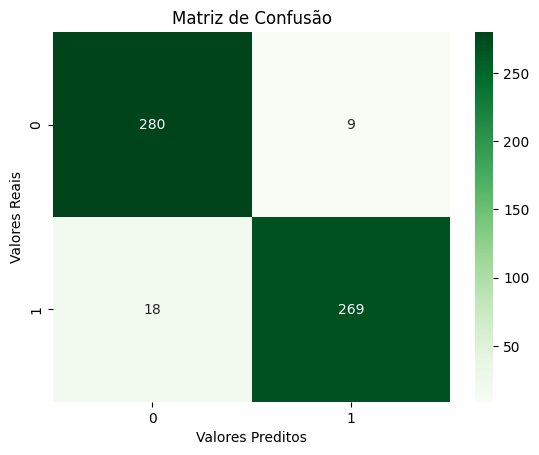

In [169]:
fig, ax = plt.subplots()
matriz_confusao = confusion_matrix(y_test, ytest_pred_class)
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Greens', ax=ax);
ax.set_title('Matriz de Confusão');
ax.set_xlabel('Valores Preditos');
ax.set_ylabel('Valores Reais');

In [170]:
# Gerando o relatório de classificação
report = classification_report(y_test, ytest_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       289
           1       0.97      0.94      0.95       287

    accuracy                           0.95       576
   macro avg       0.95      0.95      0.95       576
weighted avg       0.95      0.95      0.95       576



Lembrando:

* **Precision:** foca na qualidade das predições positivas. Útil quando o custo de prever um FP é alto.
* **Recall:** foca em encontrar o maior número possível de positivos reais. É importante quando o custo de um FN é alto.
* **F1-Score:** balanceia os dois, útil quando ambos são igualmente importantes.
* **Acurácia (Accuracy):**  proporção de todas as previsões corretas.

In [175]:
reg_log = LogisticRegression(random_state=50)
reg_log.fit(xtrain_std, y_train)
reg_log.__dict__

{'penalty': 'l2',
 'dual': False,
 'tol': 0.0001,
 'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': 50,
 'solver': 'lbfgs',
 'max_iter': 100,
 'multi_class': 'deprecated',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None,
 'l1_ratio': None,
 'n_features_in_': 7,
 'classes_': array([0, 1]),
 'n_iter_': array([7], dtype=int32),
 'coef_': array([[ 1.32058742e-03,  6.15180344e-01,  1.20523094e+00,
          1.22485093e-01, -8.95155858e-02, -2.33515972e+00,
         -9.36081311e-02]]),
 'intercept_': array([0.11291741])}

In [181]:
y_pred_log = reg_log.predict(x_test_std)

In [180]:

# Alterando a probabilidade de corte:
probabilidades = reg_log.predict_proba(x_test_std)[:, 1] # P(Y=1)
threshold = 0.7
classe_pred = (probabilidades >= threshold).astype(int)

# Predições:
print('Predições com threshold =', threshold)
print(classe_pred[0:14])

print('\nProbabilidades da classe 1')
print(np.round(probabilidades[0:14], 2))

Predições com threshold = 0.7
[0 1 0 0 0 0 0 0 0 0 1 0 0 1]

Probabilidades da classe 1
[0.17 0.87 0.67 0.69 0.   0.69 0.01 0.23 0.61 0.51 1.   0.43 0.61 0.97]


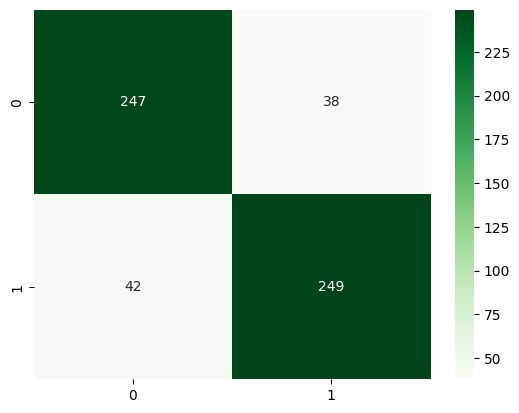

In [184]:
matriz_conf_log = confusion_matrix(y_pred_log, y_test)
sns.heatmap(matriz_conf_log, annot=True, fmt='d', cmap='Greens');

In [187]:
report_log = classification_report(y_pred_log, y_test)
print(report_log)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       285
           1       0.87      0.86      0.86       291

    accuracy                           0.86       576
   macro avg       0.86      0.86      0.86       576
weighted avg       0.86      0.86      0.86       576



## **Detectção de anomalias**

In [193]:
!pip install pyod -q

In [194]:
import pyod
from pyod.models.auto_encoder import AutoEncoder

In [195]:
dados_treino = dados.sample(n=int(0.70*len(dados)))
dados_teste = dados.sample(n=int(0.3*len(dados)))

print(dados_treino.shape)
print(dados_teste.shape)

(1612, 8)
(691, 8)


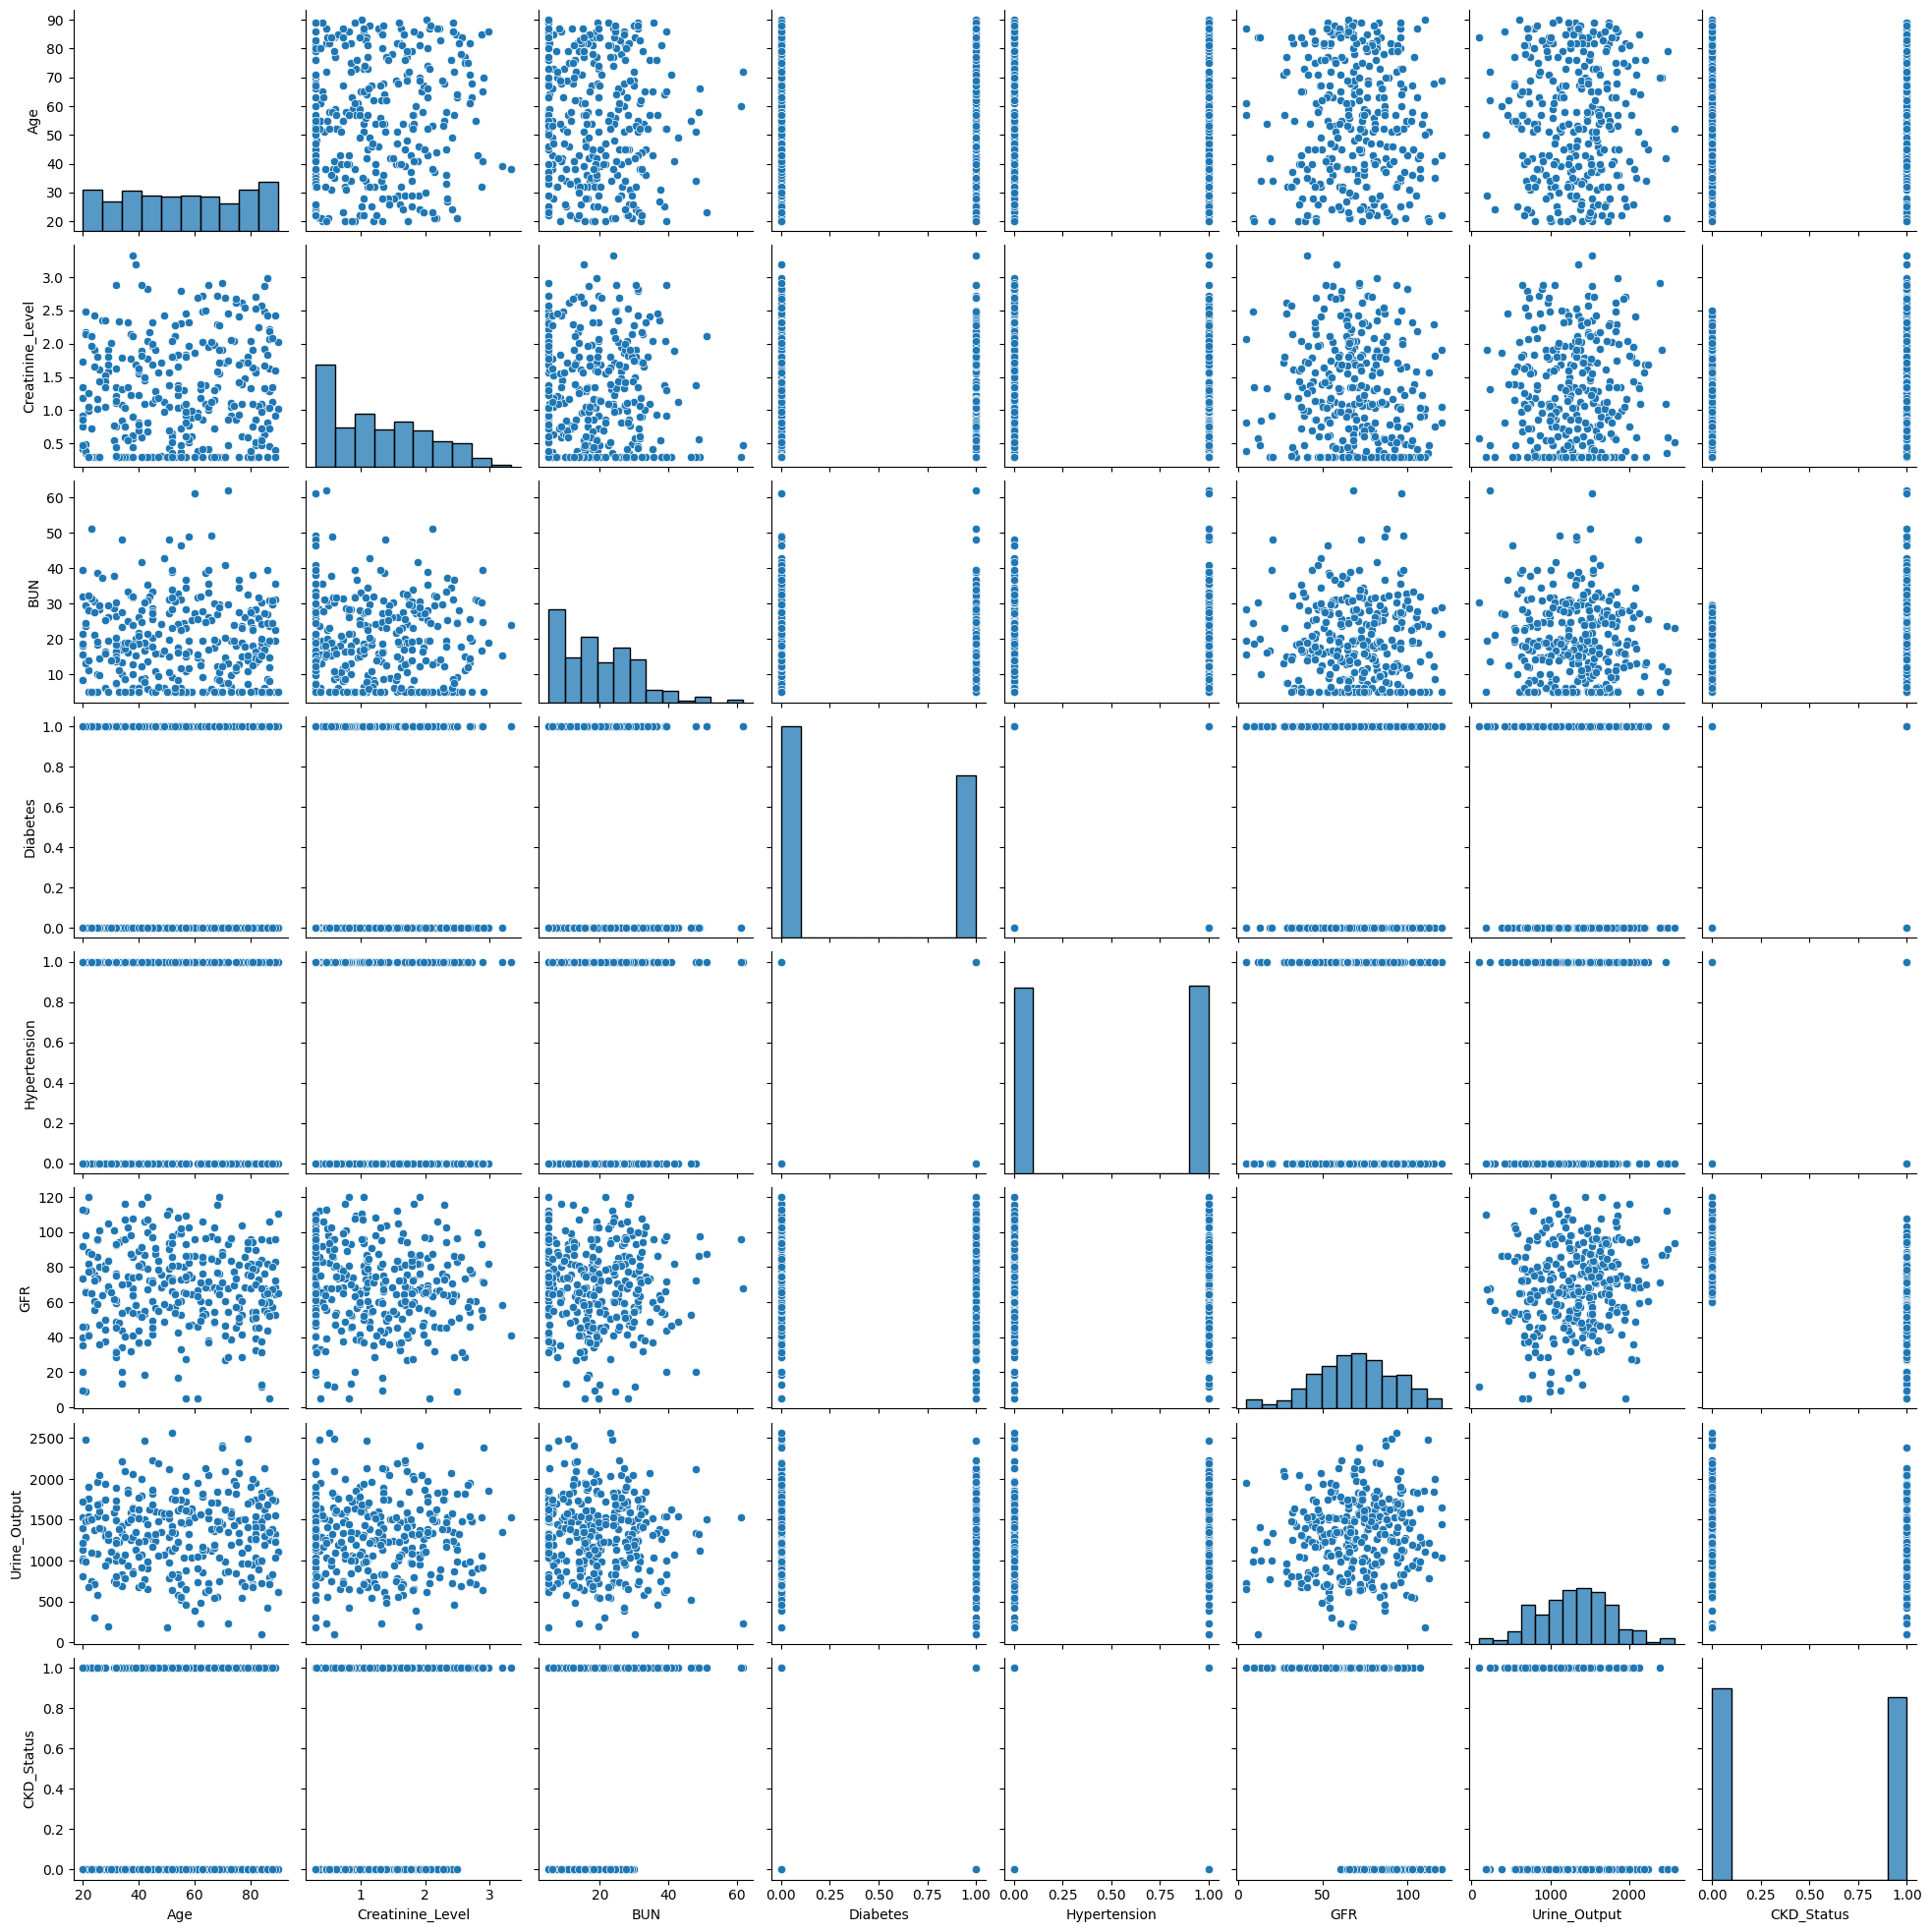

In [198]:
sns.pairplot(dados_treino.sample(int(0.2*len(dados_treino))))

In [200]:
scaler = StandardScaler()

# Scaling:
dados_treino_std = scaler.fit_transform(dados_treino)
dados_teste_std = scaler.fit_transform(dados_teste)

print(dados_treino_std.shape)
print(dados_teste_std.shape)

(1612, 8)
(691, 8)


In [202]:
rede_autoencoder = AutoEncoder(
    hidden_neuron_list=[20, 10, 20],
    batch_size=32, epoch_num=125
)
rede_autoencoder.fit(dados_treino_std)

Training: 100%|██████████| 125/125 [00:32<00:00,  3.90it/s]


In [203]:
# Resultado das predições:
dados_treino['anomalia'] =  rede_autoencoder.predict(dados_treino_std)
dados_treino['score'] =  rede_autoencoder.decision_function(dados_treino_std)
dados_treino

Age  Creatinine_Level   BUN  Diabetes  Hypertension   GFR  Urine_Output  \
1484   74              2.17   9.6         1             0  43.0        1848.0   
317    44              0.89   9.2         1             1  82.3        2044.0   
1206   78              1.96  25.6         0             1  66.9        1309.0   
838    26              1.54  12.7         0             0  48.2        1281.0   
1771   29              2.47   8.5         0             1  72.1         633.0   
...   ...               ...   ...       ...           ...   ...           ...   
1679   24              1.38   5.0         0             1  57.2        2553.0   
1611   27              2.35  37.4         0             1  64.1        1386.0   
2033   47              0.82   7.0         1             1  30.2        1844.0   
389    88              1.57  24.0         0             0  52.1         575.0   
2016   84              0.48  20.0         0             0  13.1        1410.0   

      CKD_Status  anomalia     score  
1484           1         0  1.985565  
317            0         0  1.719503  
1206           0         0  1.844608  
838            1         0  1.726971  
1771           0         0  2.501414  
...          ...       ...       ...  
1679           1         1  3.024820  
1611           1         0  2.227114  
2033           1         0  2.418630  
389            1         0  1.977921  
2016           1         0  2.495554  

[1612 rows x 10 columns]

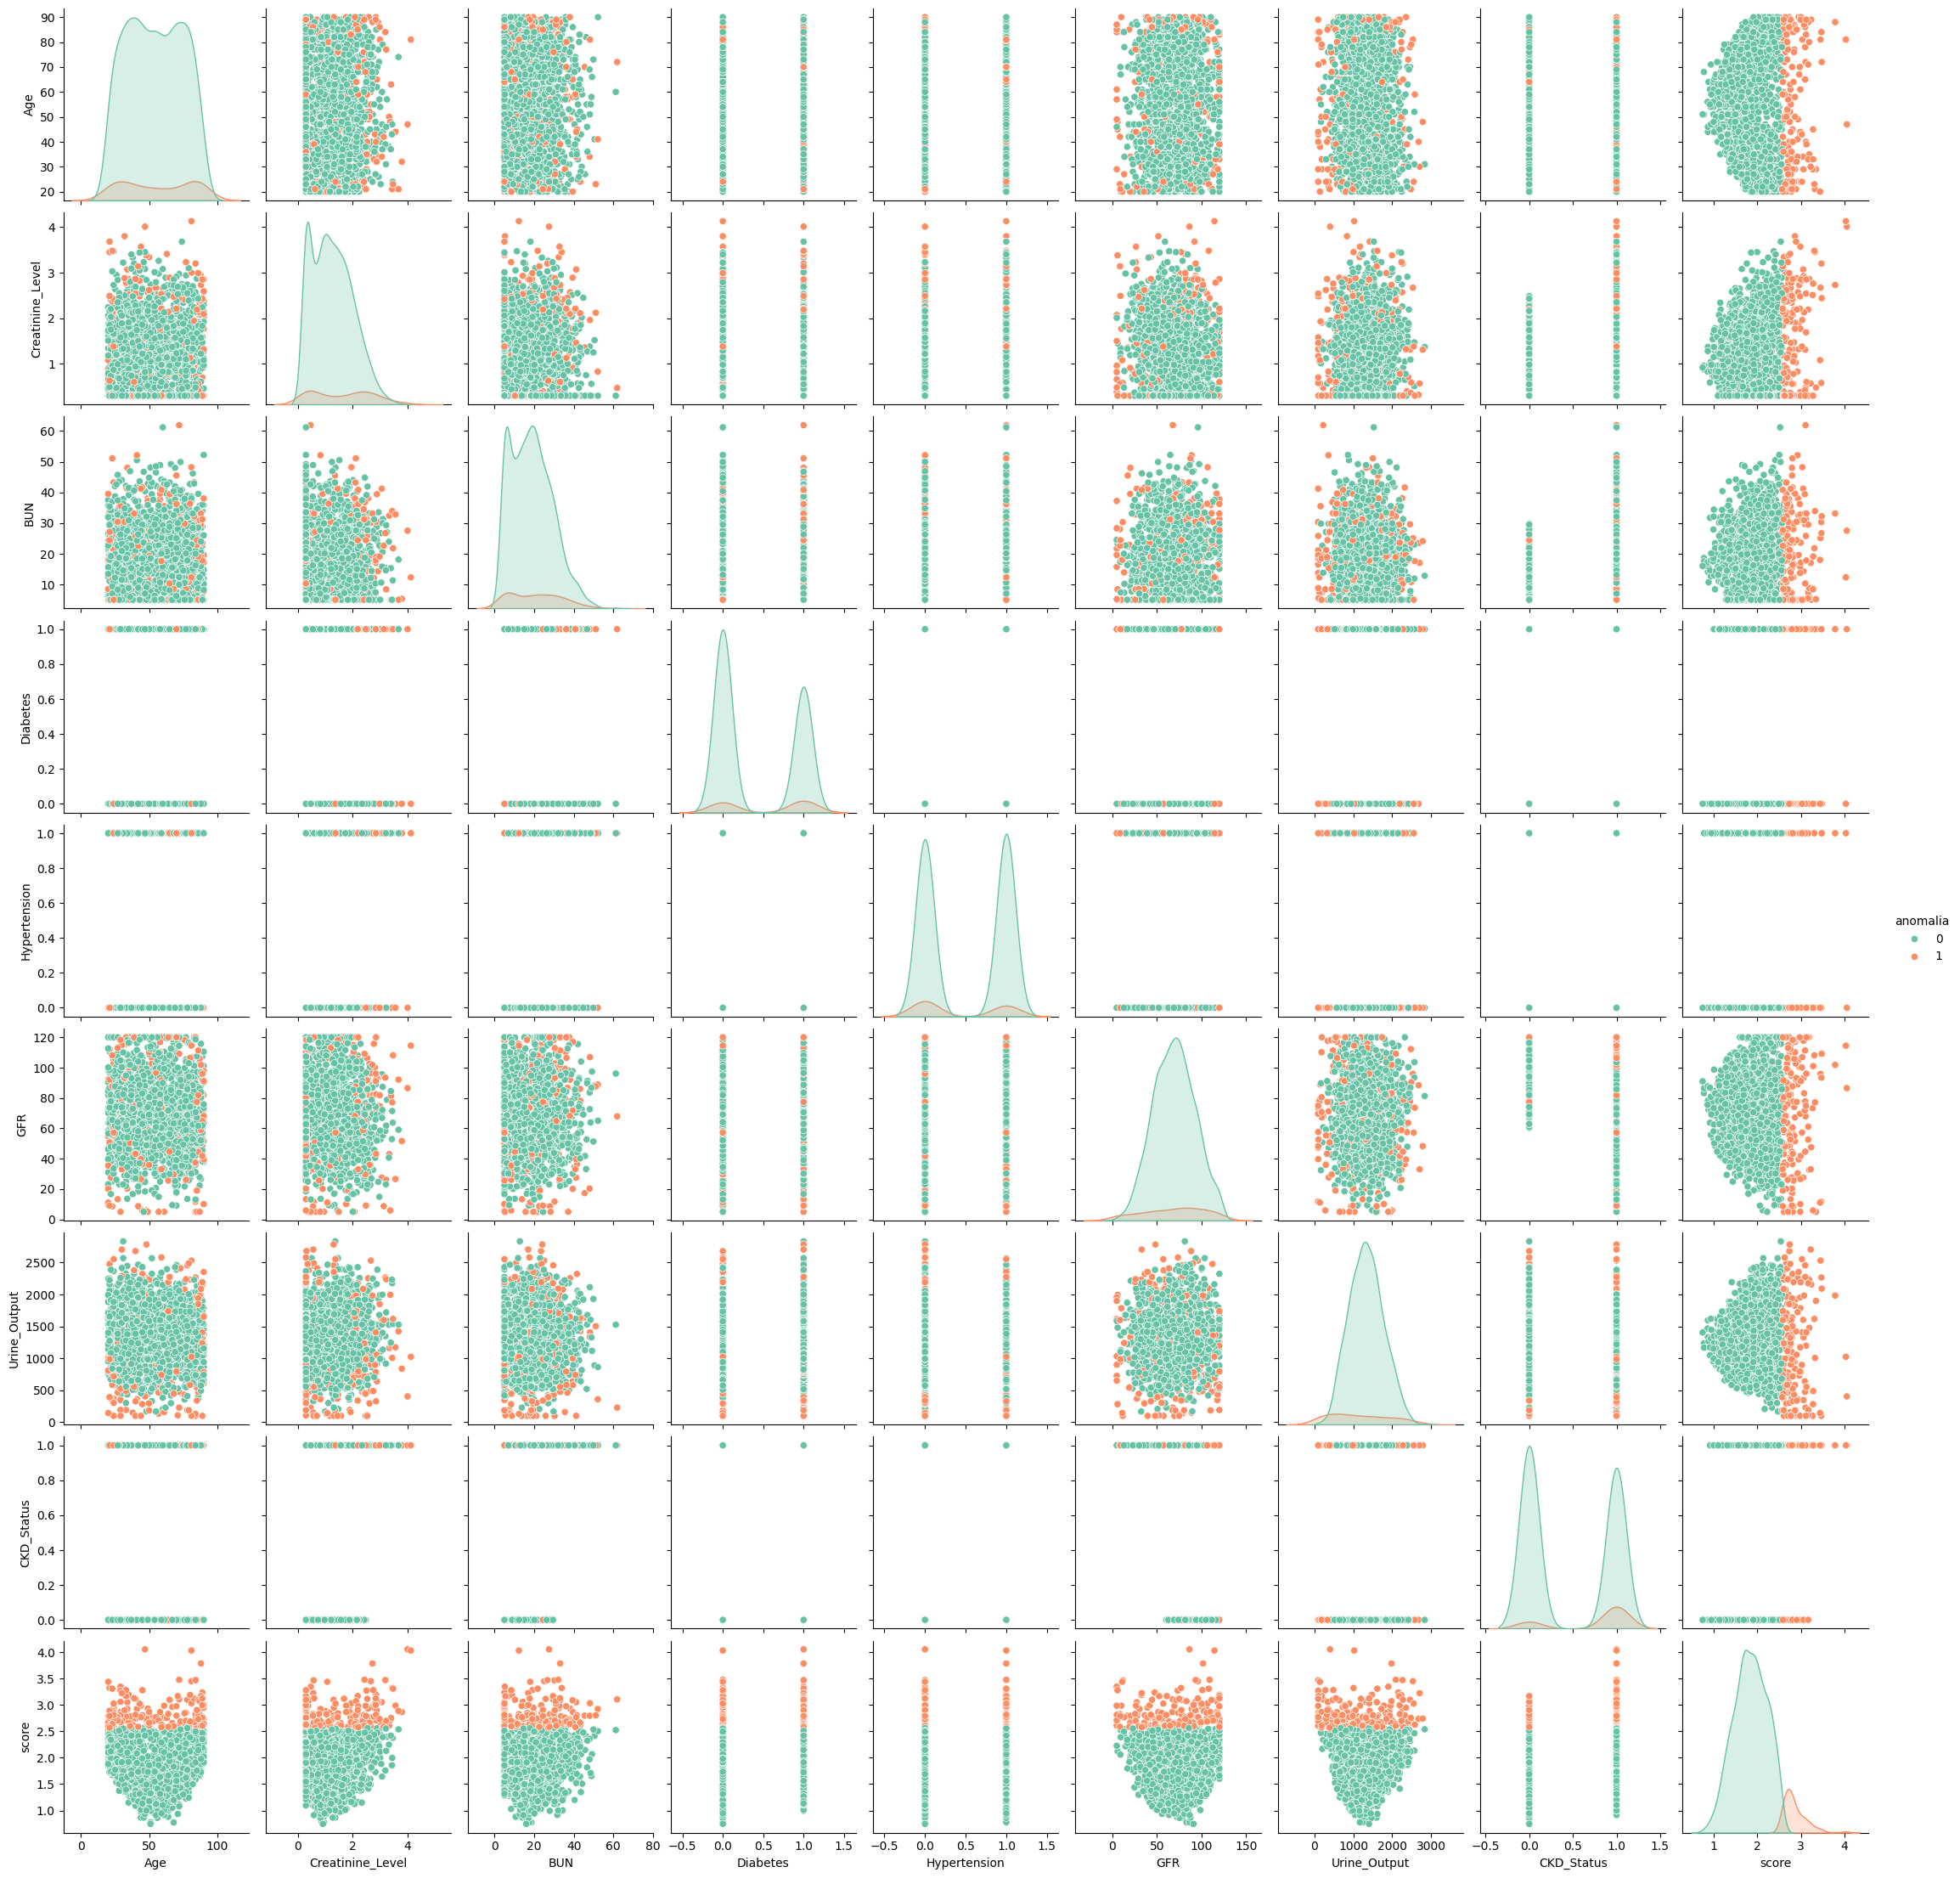

In [204]:
sns.pairplot(dados_treino, hue='anomalia', palette='Set2')

In [208]:
dados_treino['anomalia'].value_counts(normalize=True)

anomalia
0    0.899504
1    0.100496
Name: proportion, dtype: float64

In [205]:
rede_autoencoder_2 = AutoEncoder(
    hidden_neuron_list=[30, 15, 10, 15, 30],
    batch_size=16, epoch_num=125
)
rede_autoencoder_2.fit(dados_treino_std)

Training: 100%|██████████| 125/125 [01:43<00:00,  1.21it/s]


In [206]:
# Resultado das predições:
dados_treino['anomalia_ae2'] =  rede_autoencoder_2.predict(dados_treino_std)
dados_treino['score_ae2'] =  rede_autoencoder_2.decision_function(dados_treino_std)
dados_treino

Age  Creatinine_Level   BUN  Diabetes  Hypertension   GFR  Urine_Output  \
1484   74              2.17   9.6         1             0  43.0        1848.0   
317    44              0.89   9.2         1             1  82.3        2044.0   
1206   78              1.96  25.6         0             1  66.9        1309.0   
838    26              1.54  12.7         0             0  48.2        1281.0   
1771   29              2.47   8.5         0             1  72.1         633.0   
...   ...               ...   ...       ...           ...   ...           ...   
1679   24              1.38   5.0         0             1  57.2        2553.0   
1611   27              2.35  37.4         0             1  64.1        1386.0   
2033   47              0.82   7.0         1             1  30.2        1844.0   
389    88              1.57  24.0         0             0  52.1         575.0   
2016   84              0.48  20.0         0             0  13.1        1410.0   

      CKD_Status  anomalia     score  anomalia_ae2  score_ae2  
1484           1         0  1.985565             0   2.214726  
317            0         0  1.719503             0   1.640226  
1206           0         0  1.844608             0   2.175335  
838            1         0  1.726971             0   2.032742  
1771           0         0  2.501414             0   2.892442  
...          ...       ...       ...           ...        ...  
1679           1         1  3.024820             1   3.532690  
1611           1         0  2.227114             0   2.621035  
2033           1         0  2.418630             0   2.791371  
389            1         0  1.977921             0   2.418632  
2016           1         0  2.495554             0   2.594704  

[1612 rows x 12 columns]

In [207]:
dados_treino['anomalia_ae2'].value_counts(normalize=True)

anomalia_ae2
0    0.899504
1    0.100496
Name: proportion, dtype: float64

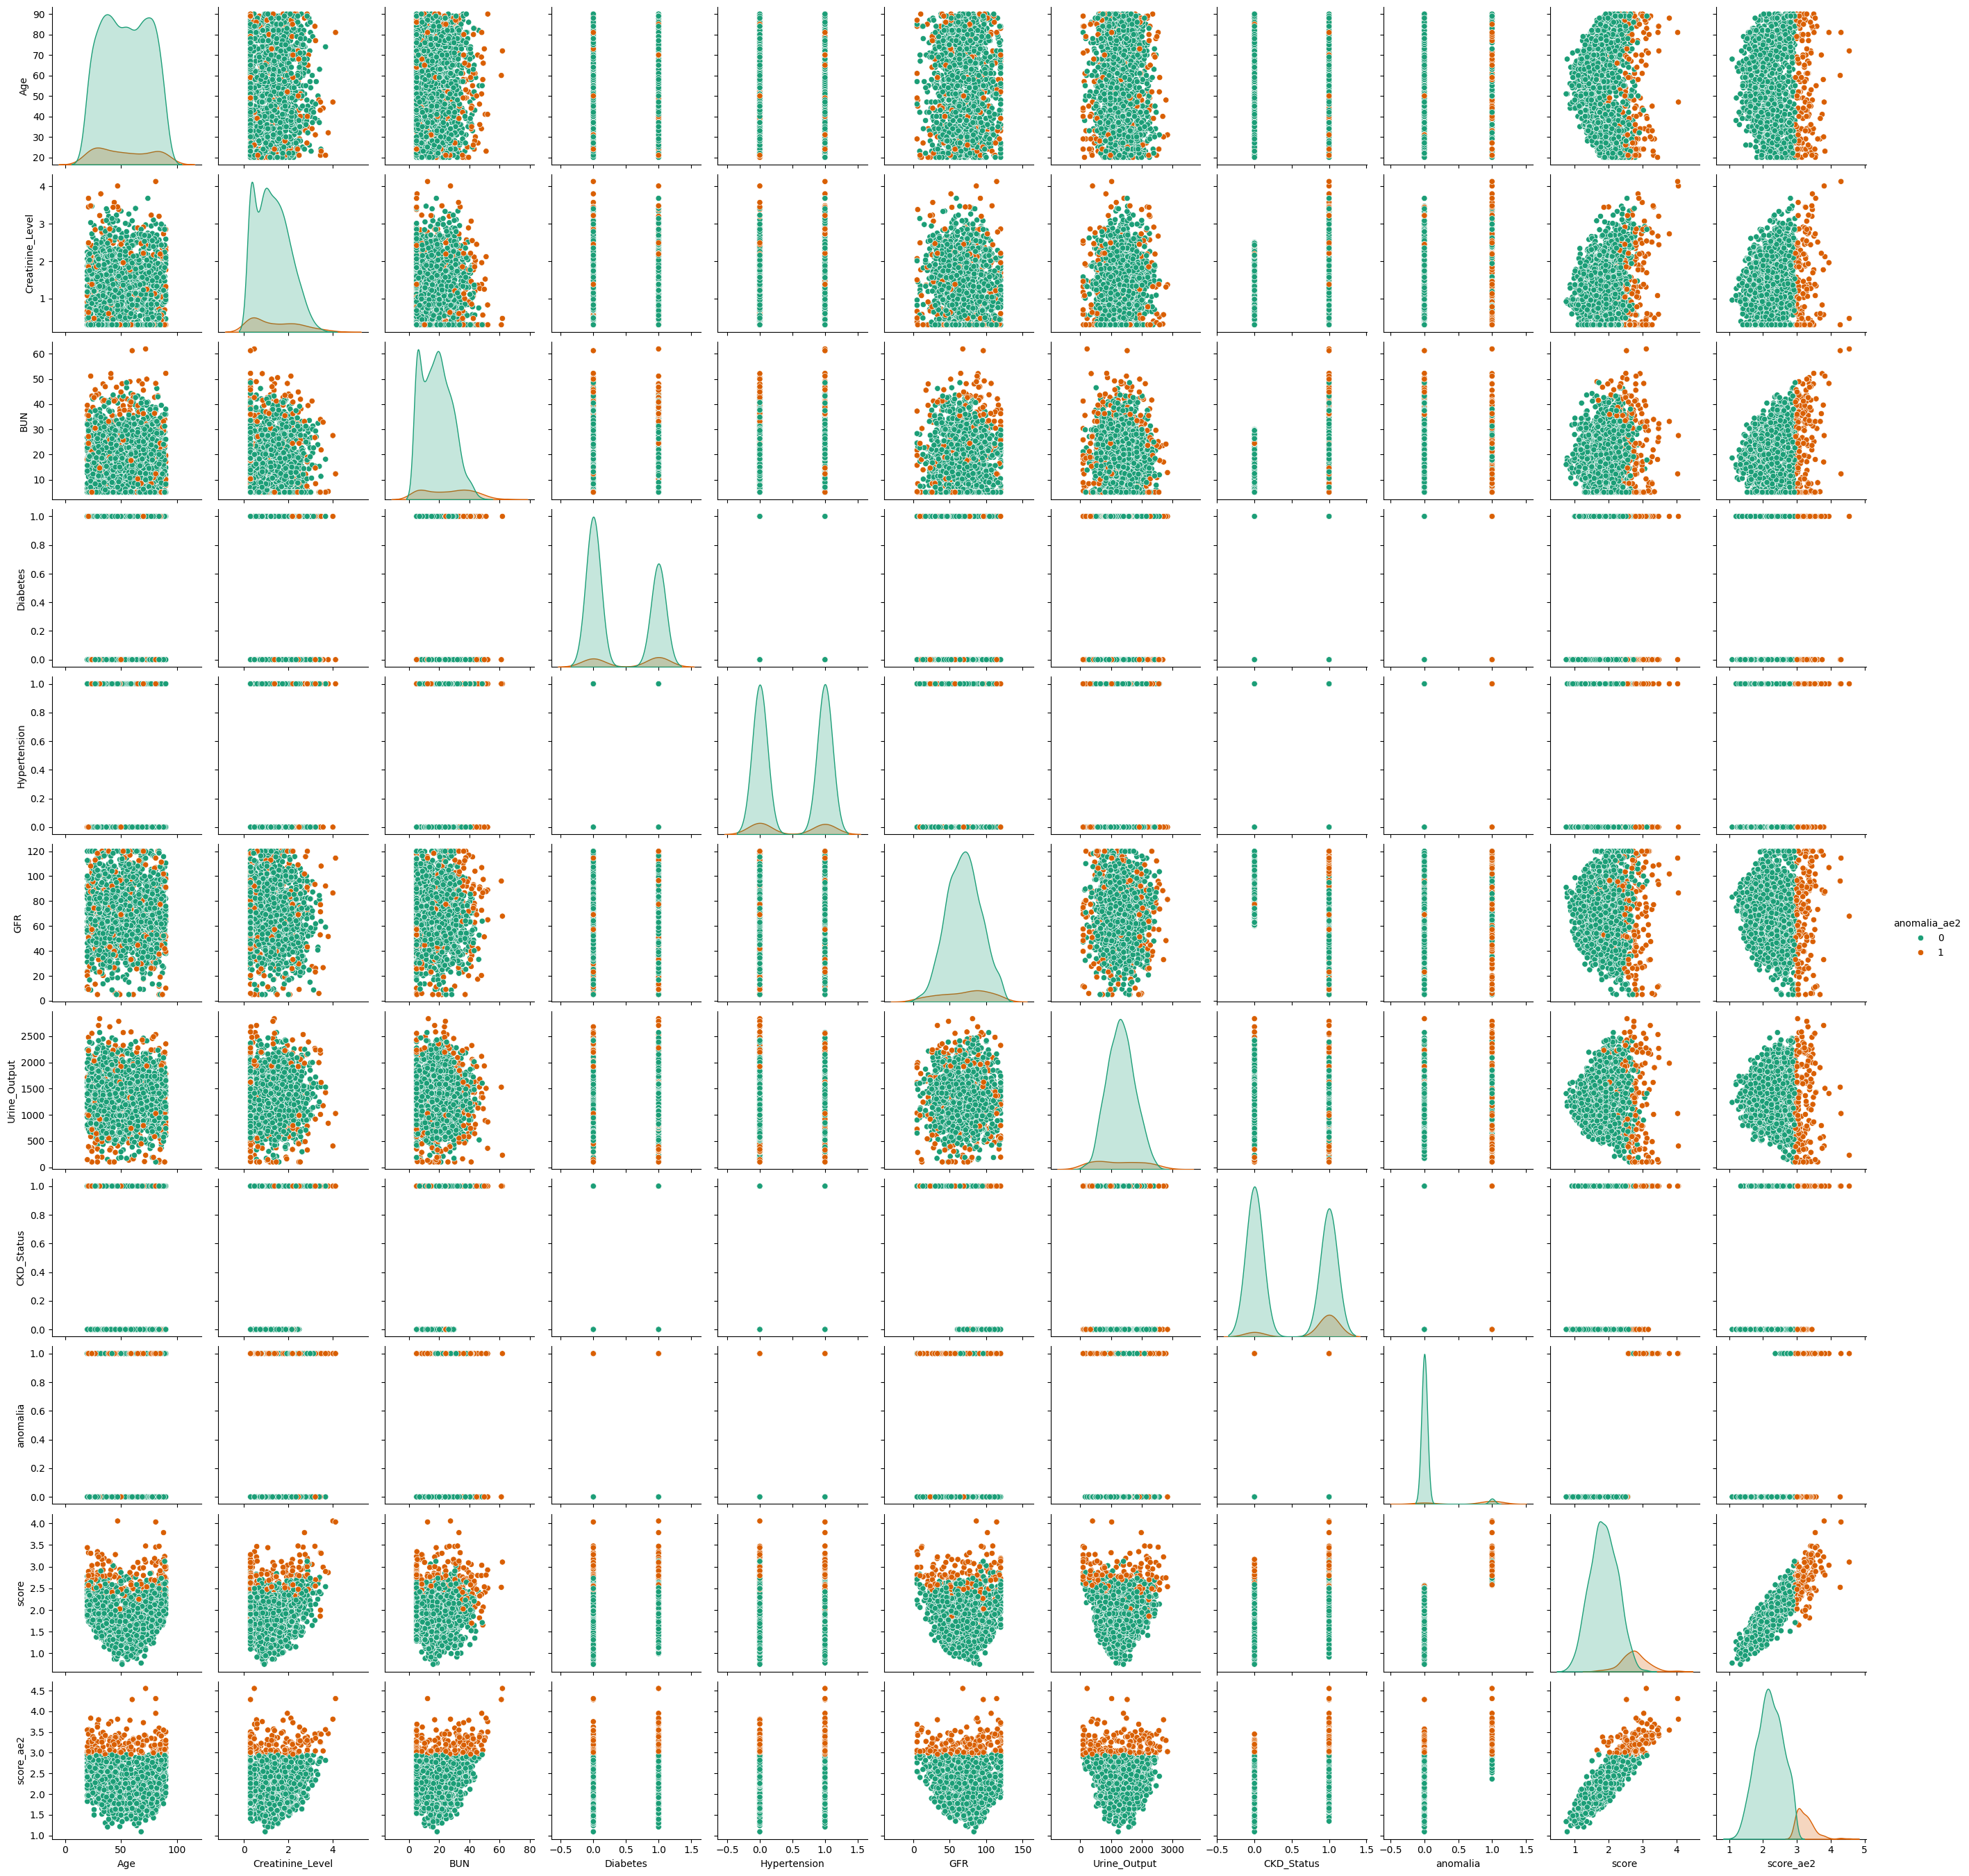

In [210]:
sns.pairplot(dados_treino, hue='anomalia_ae2', palette='Dark2')